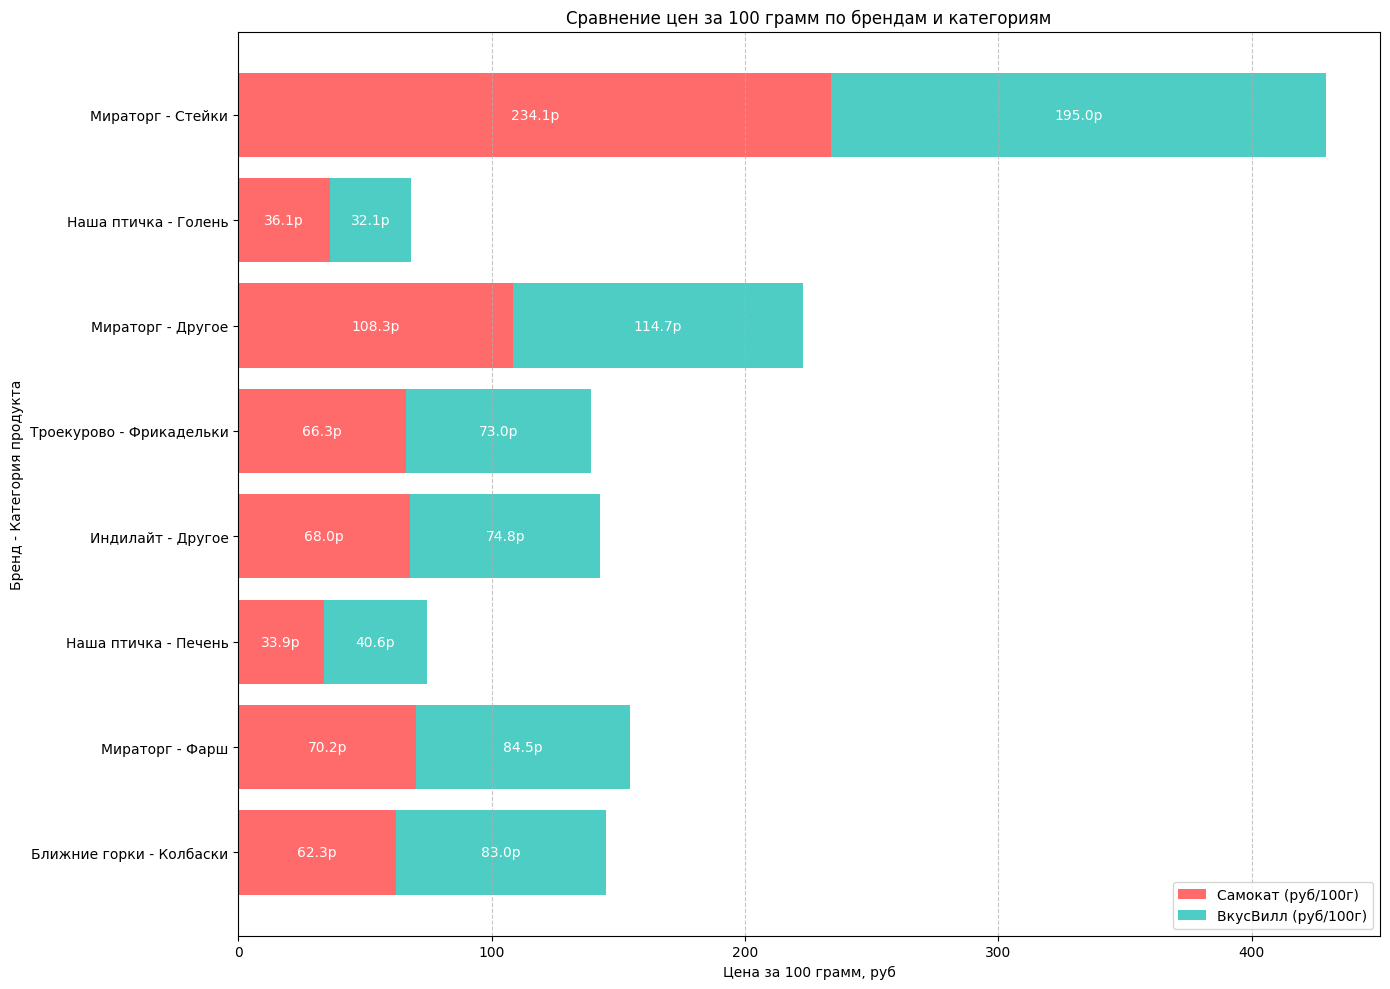

Топ-5 самых выгодных позиций в Самокате:
      brand    category  price_per_100g_samokat  price_per_100g_vkusvill  price_diff_percent
   Мираторг      Стейки              234.137931               195.000000          -16.715758
Наша птичка      Голень               36.111111                32.096296          -11.117949
   Мираторг      Другое              108.333333               114.726721            5.901588
 Троекурово Фрикадельки               66.333333                73.000000           10.050251
   Индилайт      Другое               67.992424                74.833333           10.061281

Топ-5 самых выгодных позиций во ВкусВилле:
        brand    category  price_per_100g_samokat  price_per_100g_vkusvill  price_diff_percent
Ближние горки    Колбаски               62.250000                83.000000           33.333333
     Мираторг        Фарш               70.250000                84.500000           20.284698
  Наша птичка      Печень               33.877551                40.6122

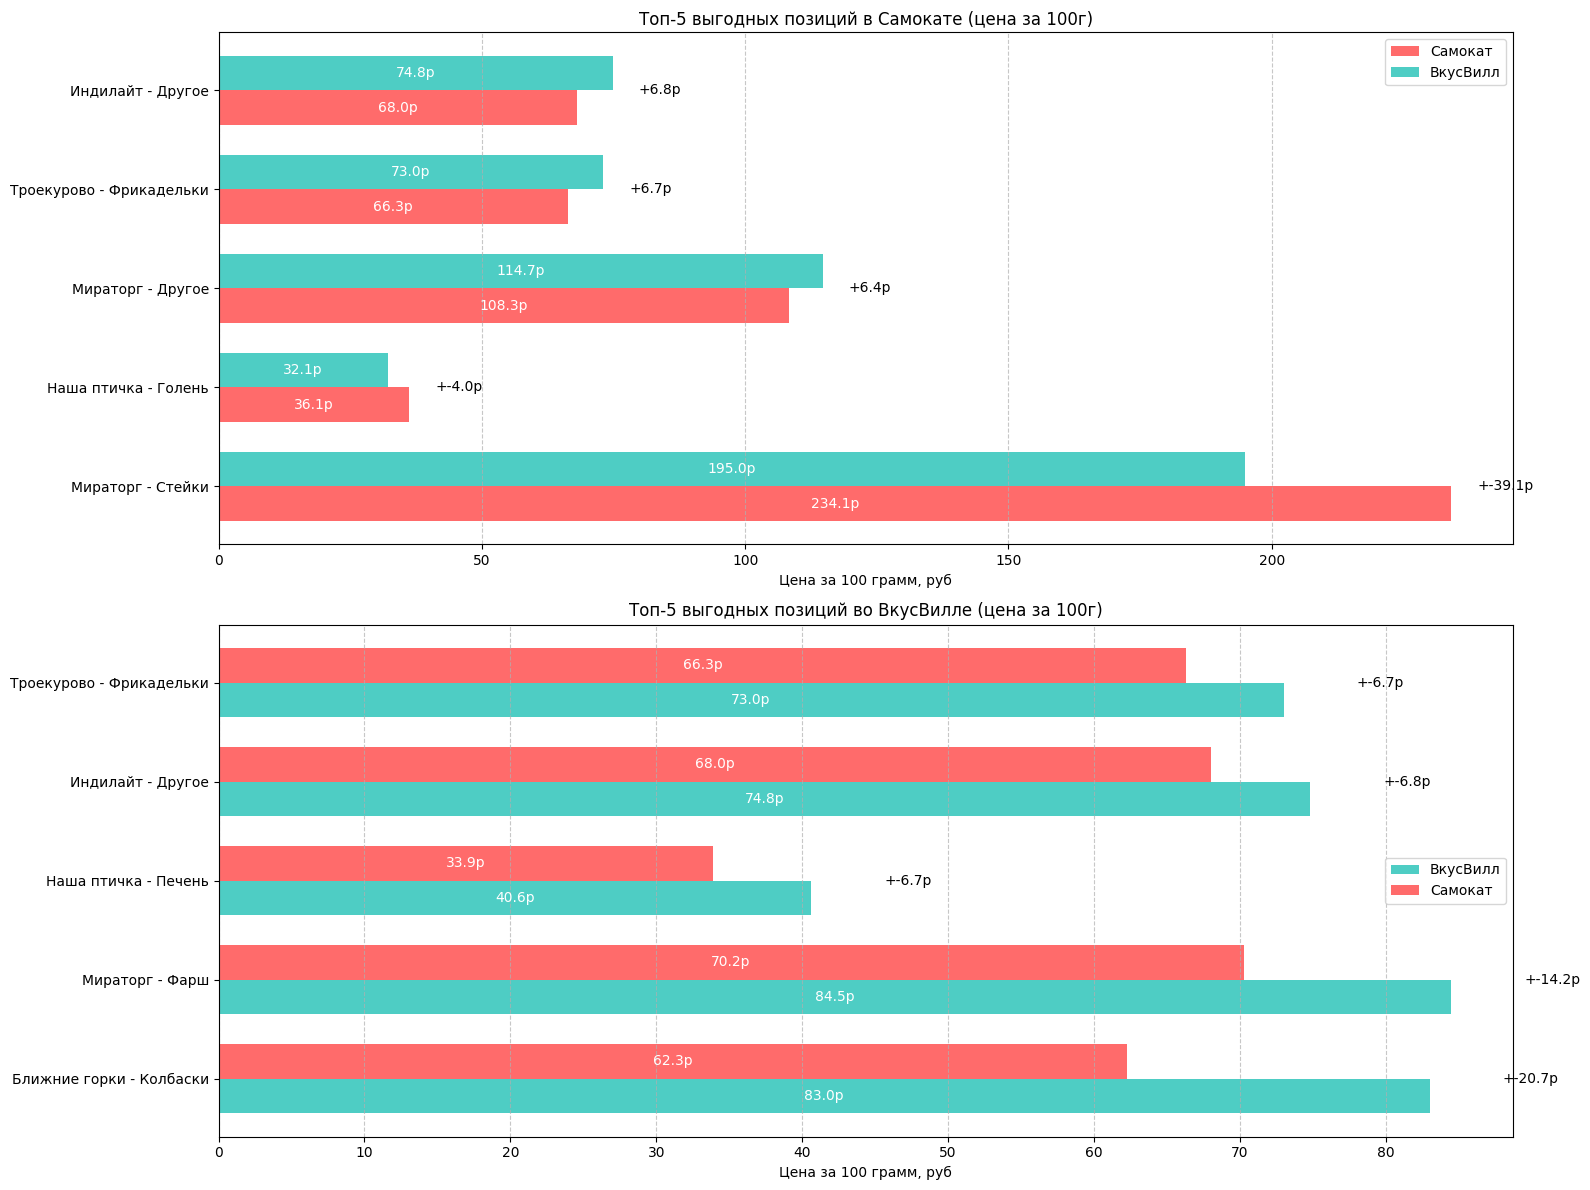

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import re
""" Визуализация для категории "мясо" . Представлен график
сравнения цен в двух магазинахи топ 5 самых выгодных товаров из каждого"""
# Загрузка данных
samokat = pd.read_csv('samokat_myaso_filtered.csv')
vkusvill = pd.read_csv('vkusvill_myaso_filtered.csv')

# Функция для извлечения числового значения веса
def extract_weight(weight_str):
    if pd.isna(weight_str): return None
    weight_str = str(weight_str).replace(' ', '')
    match = re.search(r'(\d+\.?\d*)\s*г|кг', weight_str.lower())
    if not match: return None
    weight = float(match.group(1))
    if 'кг' in weight_str.lower(): weight *= 1000  # конвертируем кг в граммы
    return weight

# Применяем функцию к столбцам веса
samokat['weight_grams'] = samokat['weight'].apply(extract_weight)
vkusvill['weight_grams'] = vkusvill['weight'].apply(extract_weight)

# Удаляем строки с отсутствующим весом
samokat = samokat.dropna(subset=['weight_grams'])
vkusvill = vkusvill.dropna(subset=['weight_grams'])

# Рассчитываем цену за 100 грамм
samokat['price_per_100g'] = (samokat['price'] / samokat['weight_grams']) * 100
vkusvill['price_per_100g'] = (vkusvill['price'] / vkusvill['weight_grams']) * 100

# Нормализация брендов (как в предыдущем коде)
def normalize_brand(brand):
    brand = str(brand).lower()
    if 'инди' in brand: return 'Индилайт'
    if 'рококо' in brand: return 'Рококо'
    if 'ближние' in brand: return 'Ближние горки'
    if 'наша' in brand: return 'Наша птичка'
    if 'мираторг' in brand: return 'Мираторг'
    if 'троекурово' in brand: return 'Троекурово'
    return brand.title()

samokat['brand'] = samokat['brand'].apply(normalize_brand)
vkusvill['brand'] = vkusvill['brand'].apply(normalize_brand)

# Классификация продуктов (как в предыдущем коде)
def classify_product(name):
    name = str(name).lower()
    if 'колбас' in name: return 'Колбаски'
    if 'фрикадел' in name: return 'Фрикадельки'
    if 'стейк' in name: return 'Стейки'
    if 'шашл' in name or 'купат' in name: return 'Шашлык/купаты'
    if 'грудк' in name: return 'Филе грудки'
    if 'бедр' in name: return 'Бедро'
    if 'голен' in name: return 'Голень'
    if 'печен' in name: return 'Печень'
    if 'фарш' in name: return 'Фарш'
    return 'Другое'

samokat['category'] = samokat['name'].apply(classify_product)
vkusvill['category'] = vkusvill['name'].apply(classify_product)

# Группируем по бренду и категории, считая среднюю цену за 100г
samokat_grouped = samokat.groupby(['brand', 'category'])['price_per_100g'].mean().reset_index()
vkusvill_grouped = vkusvill.groupby(['brand', 'category'])['price_per_100g'].mean().reset_index()

# Объединяем для сравнения
comparison = pd.merge(
    samokat_grouped,
    vkusvill_grouped,
    on=['brand', 'category'],
    suffixes=('_samokat', '_vkusvill'),
    how='inner'
)

# Рассчитываем разницу
comparison['price_diff'] = comparison['price_per_100g_vkusvill'] - comparison['price_per_100g_samokat']
comparison['price_diff_percent'] = (comparison['price_diff'] / comparison['price_per_100g_samokat']) * 100
comparison = comparison.sort_values('price_diff_percent', ascending=False)

# Визуализация
plt.figure(figsize=(14, 10))
bars = plt.barh(
    comparison['brand'] + ' - ' + comparison['category'],
    comparison['price_per_100g_samokat'],
    color='#FF6B6B',
    label='Самокат (руб/100г)'
)
plt.barh(
    comparison['brand'] + ' - ' + comparison['category'],
    comparison['price_per_100g_vkusvill'],
    color='#4ECDC4',
    label='ВкусВилл (руб/100г)',
    left=comparison['price_per_100g_samokat']
)

# Добавляем подписи с ценами
for i, (sam, vkus) in enumerate(zip(comparison['price_per_100g_samokat'], comparison['price_per_100g_vkusvill'])):
    plt.text(sam/2, i, f"{sam:.1f}р", ha='center', va='center', color='white')
    plt.text(sam + vkus/2, i, f"{vkus:.1f}р", ha='center', va='center', color='white')

plt.title('Сравнение цен за 100 грамм по брендам и категориям')
plt.xlabel('Цена за 100 грамм, руб')
plt.ylabel('Бренд - Категория продукта')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('price_comparison_per_100g.png', dpi=300, bbox_inches='tight')
plt.show()


# Вывод результатов
print("Топ-5 самых выгодных позиций в Самокате:")
print(comparison.nsmallest(5, 'price_diff_percent')[['brand', 'category', 'price_per_100g_samokat', 'price_per_100g_vkusvill', 'price_diff_percent']].to_string(index=False))

print("\nТоп-5 самых выгодных позиций во ВкусВилле:")
print(comparison.nlargest(5, 'price_diff_percent')[['brand', 'category', 'price_per_100g_samokat', 'price_per_100g_vkusvill', 'price_diff_percent']].to_string(index=False))

# Сохранение результатов
comparison.to_csv('price_comparison_per_100g.csv', index=False)
# Создаем фигуру с двумя графиками
plt.figure(figsize=(16, 12))

# Топ-5 выгодных позиций в Самокате
plt.subplot(2, 1, 1)  # 2 строки, 1 столбец, первый график
top_samokat = comparison.nsmallest(5, 'price_diff_percent')
y_pos = np.arange(len(top_samokat))
bar_width = 0.35

plt.barh(y_pos - bar_width/2, top_samokat['price_per_100g_samokat'], 
         height=bar_width, color='#FF6B6B', label='Самокат')
plt.barh(y_pos + bar_width/2, top_samokat['price_per_100g_vkusvill'], 
         height=bar_width, color='#4ECDC4', label='ВкусВилл')

# Добавляем значения цен на столбцы
for i, (sam, vkus) in enumerate(zip(top_samokat['price_per_100g_samokat'], 
                                  top_samokat['price_per_100g_vkusvill'])):
    plt.text(sam/2, i - bar_width/2, f"{sam:.1f}р", ha='center', va='center', color='white')
    plt.text(vkus/2, i + bar_width/2, f"{vkus:.1f}р", ha='center', va='center', color='white')
    diff = vkus - sam
    plt.text(max(sam, vkus) + 5, i, f"+{diff:.1f}р", va='center')

plt.yticks(y_pos, top_samokat['brand'] + ' - ' + top_samokat['category'])
plt.title('Топ-5 выгодных позиций в Самокате (цена за 100г)')
plt.xlabel('Цена за 100 грамм, руб')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Топ-5 выгодных позиций во ВкусВилле
plt.subplot(2, 1, 2)  # второй график
top_vkusvill = comparison.nlargest(5, 'price_diff_percent')
y_pos = np.arange(len(top_vkusvill))

plt.barh(y_pos - bar_width/2, top_vkusvill['price_per_100g_vkusvill'], 
         height=bar_width, color='#4ECDC4', label='ВкусВилл')
plt.barh(y_pos + bar_width/2, top_vkusvill['price_per_100g_samokat'], 
         height=bar_width, color='#FF6B6B', label='Самокат')

# Добавляем значения цен на столбцы
for i, (vkus, sam) in enumerate(zip(top_vkusvill['price_per_100g_vkusvill'], 
                                   top_vkusvill['price_per_100g_samokat'])):
    plt.text(vkus/2, i - bar_width/2, f"{vkus:.1f}р", ha='center', va='center', color='white')
    plt.text(sam/2, i + bar_width/2, f"{sam:.1f}р", ha='center', va='center', color='white')
    diff = sam - vkus
    plt.text(max(sam, vkus) + 5, i, f"+{diff:.1f}р", va='center')

plt.yticks(y_pos, top_vkusvill['brand'] + ' - ' + top_vkusvill['category'])
plt.title('Топ-5 выгодных позиций во ВкусВилле (цена за 100г)')
plt.xlabel('Цена за 100 грамм, руб')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('top_products_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



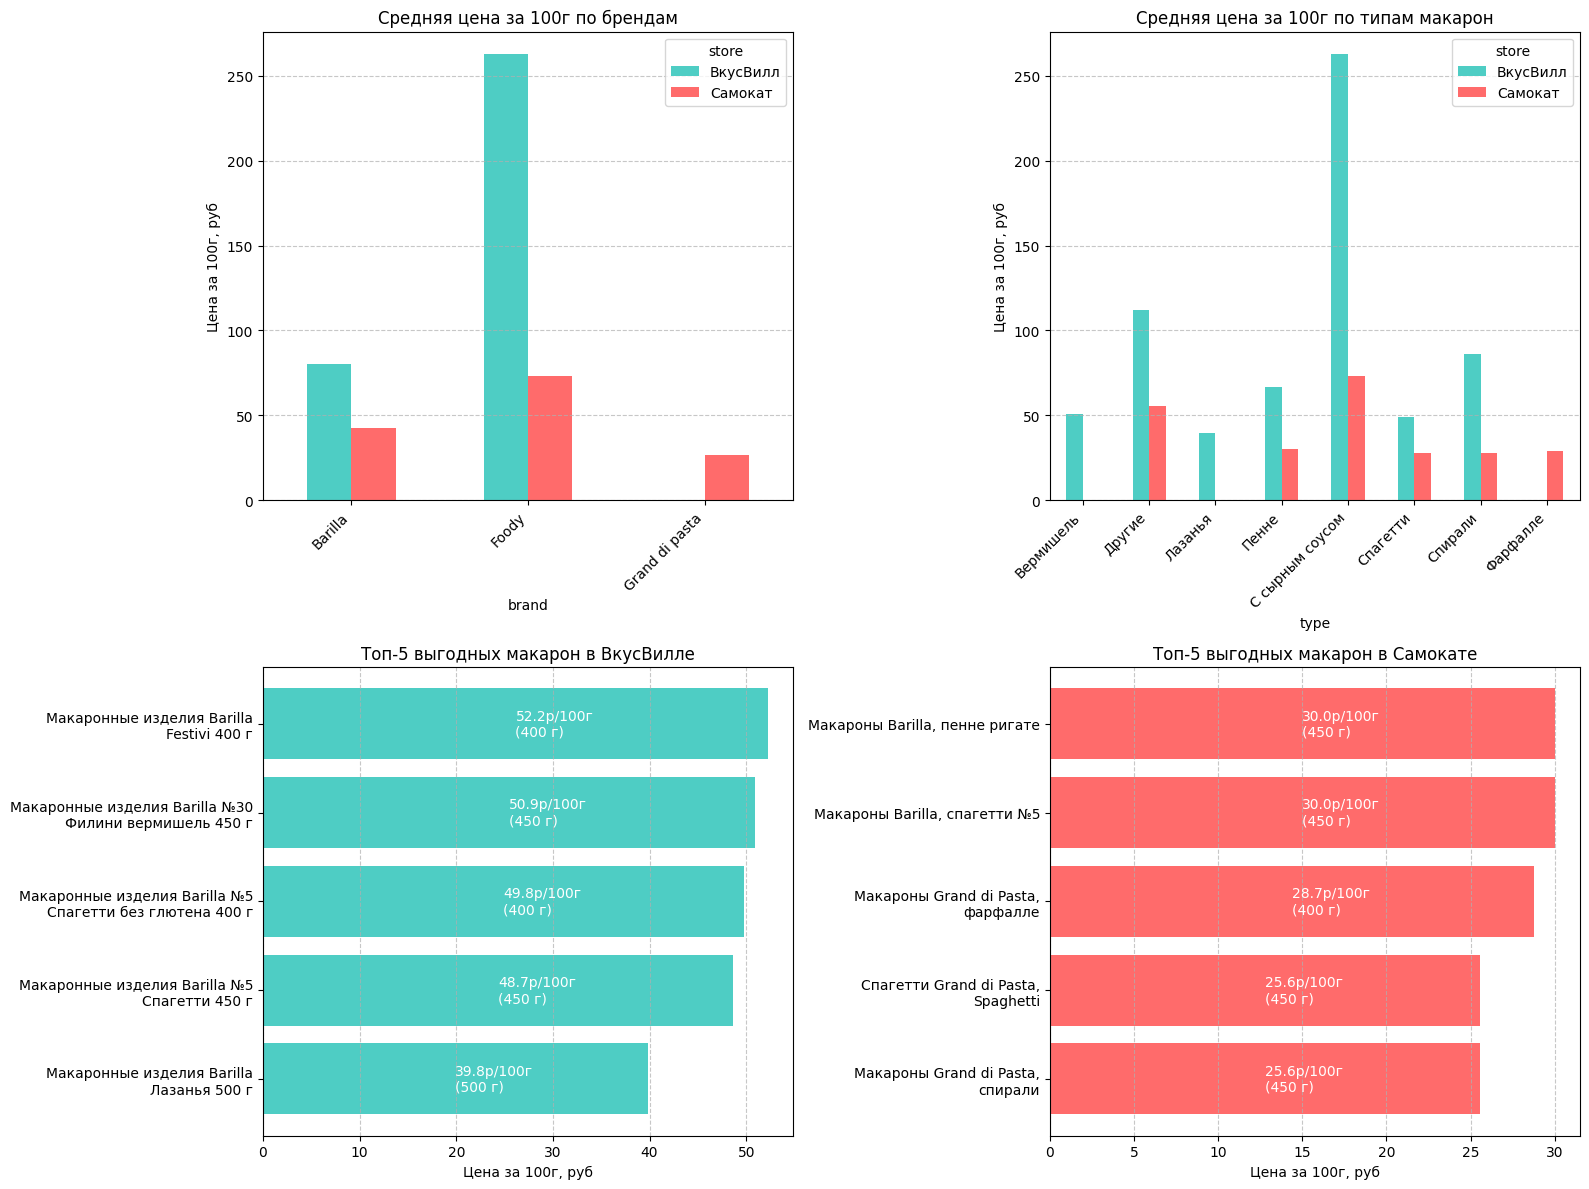

Топ-5 самых выгодных макарон в ВкусВилле:
                                                    name   brand  price weight  price_per_100g
                Макаронные изделия Barilla Лазанья 500 г Barilla  199.0  500 г       39.800000
            Макаронные изделия Barilla №5 Спагетти 450 г Barilla  219.0  450 г       48.666667
Макаронные изделия Barilla №5 Спагетти без глютена 400 г Barilla  199.0  400 г       49.750000
   Макаронные изделия Barilla №30 Филини вермишель 450 г Barilla  229.0  450 г       50.888889
                Макаронные изделия Barilla Festivi 400 г Barilla  209.0  400 г       52.250000

Топ-5 самых выгодных макарон в Самокате:
                              name          brand  price weight  price_per_100g
  Макароны Grand di Pasta, спирали Grand di pasta    115  450 г       25.555556
Спагетти Grand di Pasta, Spaghetti Grand di pasta    115  450 г       25.555556
 Макароны Grand di Pasta, фарфалле Grand di pasta    115  400 г       28.750000
     Макароны Barilla, спа

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
""" Визализация для категории "макароны" """
# Функция для обработки веса
def extract_weight(weight_str):
    if pd.isna(weight_str): return None
    weight_str = str(weight_str).replace(' ', '').replace('г', '')
    match = re.search(r'(\d+\.?\d*)', weight_str)
    return float(match.group(1)) if match else None

# Загрузка и обработка данных ВкусВилл
vkusvill = pd.read_csv('vkusvill_makarony_filtered.csv')
vkusvill['weight_grams'] = vkusvill['weight'].apply(extract_weight)
vkusvill = vkusvill.dropna(subset=['weight_grams', 'price'])
vkusvill['price_per_100g'] = (vkusvill['price'] / vkusvill['weight_grams']) * 100
vkusvill['store'] = 'ВкусВилл'

# Загрузка и обработка данных Самокат
samokat = pd.read_csv('samokat_makarony_filtered.csv')
samokat['weight_grams'] = samokat['weight'].apply(extract_weight)
samokat = samokat.dropna(subset=['weight_grams', 'price'])
samokat['price_per_100g'] = (samokat['price'] / samokat['weight_grams']) * 100
samokat['store'] = 'Самокат'

# Объединение данных
all_data = pd.concat([vkusvill, samokat])

# Классификация макарон по типам
def classify_pasta(name):
    name = str(name).lower()
    if 'спагетт' in name: return 'Спагетти'
    if 'пенне' in name: return 'Пенне'
    if 'фузилл' in name or 'спирал' in name: return 'Спирали'
    if 'фарфалл' in name or 'бант' in name: return 'Фарфалле'
    if 'лазань' in name: return 'Лазанья'
    if 'вермишел' in name: return 'Вермишель'
    if 'соус' in name or 'сырн' in name: return 'С сырным соусом'
    return 'Другие'

all_data['type'] = all_data['name'].apply(classify_pasta)

# Сравнение по брендам и типам
comparison = all_data.groupby(['brand', 'type', 'store'])['price_per_100g'].mean().unstack().reset_index()
comparison['price_diff'] = comparison['ВкусВилл'] - comparison['Самокат']
comparison['diff_percent'] = (comparison['price_diff'] / comparison['Самокат']) * 100

# Топ-5 самых выгодных позиций в каждом магазине
top_vkusvill = vkusvill.nsmallest(5, 'price_per_100g')
top_samokat = samokat.nsmallest(5, 'price_per_100g')

# Визуализация
plt.figure(figsize=(16, 12))

# График 1: Сравнение средних цен по брендам
plt.subplot(2, 2, 1)
brand_prices = all_data.groupby(['brand', 'store'])['price_per_100g'].mean().unstack()
brand_prices.plot(kind='bar', ax=plt.gca(), color=['#4ECDC4', '#FF6B6B'])
plt.title('Средняя цена за 100г по брендам')
plt.ylabel('Цена за 100г, руб')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# График 2: Сравнение по типам макарон
plt.subplot(2, 2, 2)
type_prices = all_data.groupby(['type', 'store'])['price_per_100g'].mean().unstack()
type_prices.plot(kind='bar', ax=plt.gca(), color=['#4ECDC4', '#FF6B6B'])
plt.title('Средняя цена за 100г по типам макарон')
plt.ylabel('Цена за 100г, руб')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# График 3: Топ-5 выгодных в ВкусВилле
plt.subplot(2, 2, 3)
plt.barh(
    top_vkusvill['name'].str.wrap(30),
    top_vkusvill['price_per_100g'],
    color='#4ECDC4'
)
for i, (price, weight) in enumerate(zip(top_vkusvill['price_per_100g'], top_vkusvill['weight'])):
    plt.text(price/2, i, f"{price:.1f}р/100г\n({weight})", va='center', color='white')
plt.title('Топ-5 выгодных макарон в ВкусВилле')
plt.xlabel('Цена за 100г, руб')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# График 4: Топ-5 выгодных в Самокате
plt.subplot(2, 2, 4)
plt.barh(
    top_samokat['name'].str.wrap(30),
    top_samokat['price_per_100g'],
    color='#FF6B6B'
)
for i, (price, weight) in enumerate(zip(top_samokat['price_per_100g'], top_samokat['weight'])):
    plt.text(price/2, i, f"{price:.1f}р/100г\n({weight})", va='center', color='white')
plt.title('Топ-5 выгодных макарон в Самокате')
plt.xlabel('Цена за 100г, руб')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('pasta_price_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Вывод результатов
print("Топ-5 самых выгодных макарон в ВкусВилле:")
print(top_vkusvill[['name', 'brand', 'price', 'weight', 'price_per_100g']].to_string(index=False))

print("\nТоп-5 самых выгодных макарон в Самокате:")
print(top_samokat[['name', 'brand', 'price', 'weight', 'price_per_100g']].to_string(index=False))

print("\nСравнение средних цен по брендам:")
print(comparison[['brand', 'type', 'ВкусВилл', 'Самокат', 'price_diff', 'diff_percent']].to_string(index=False))

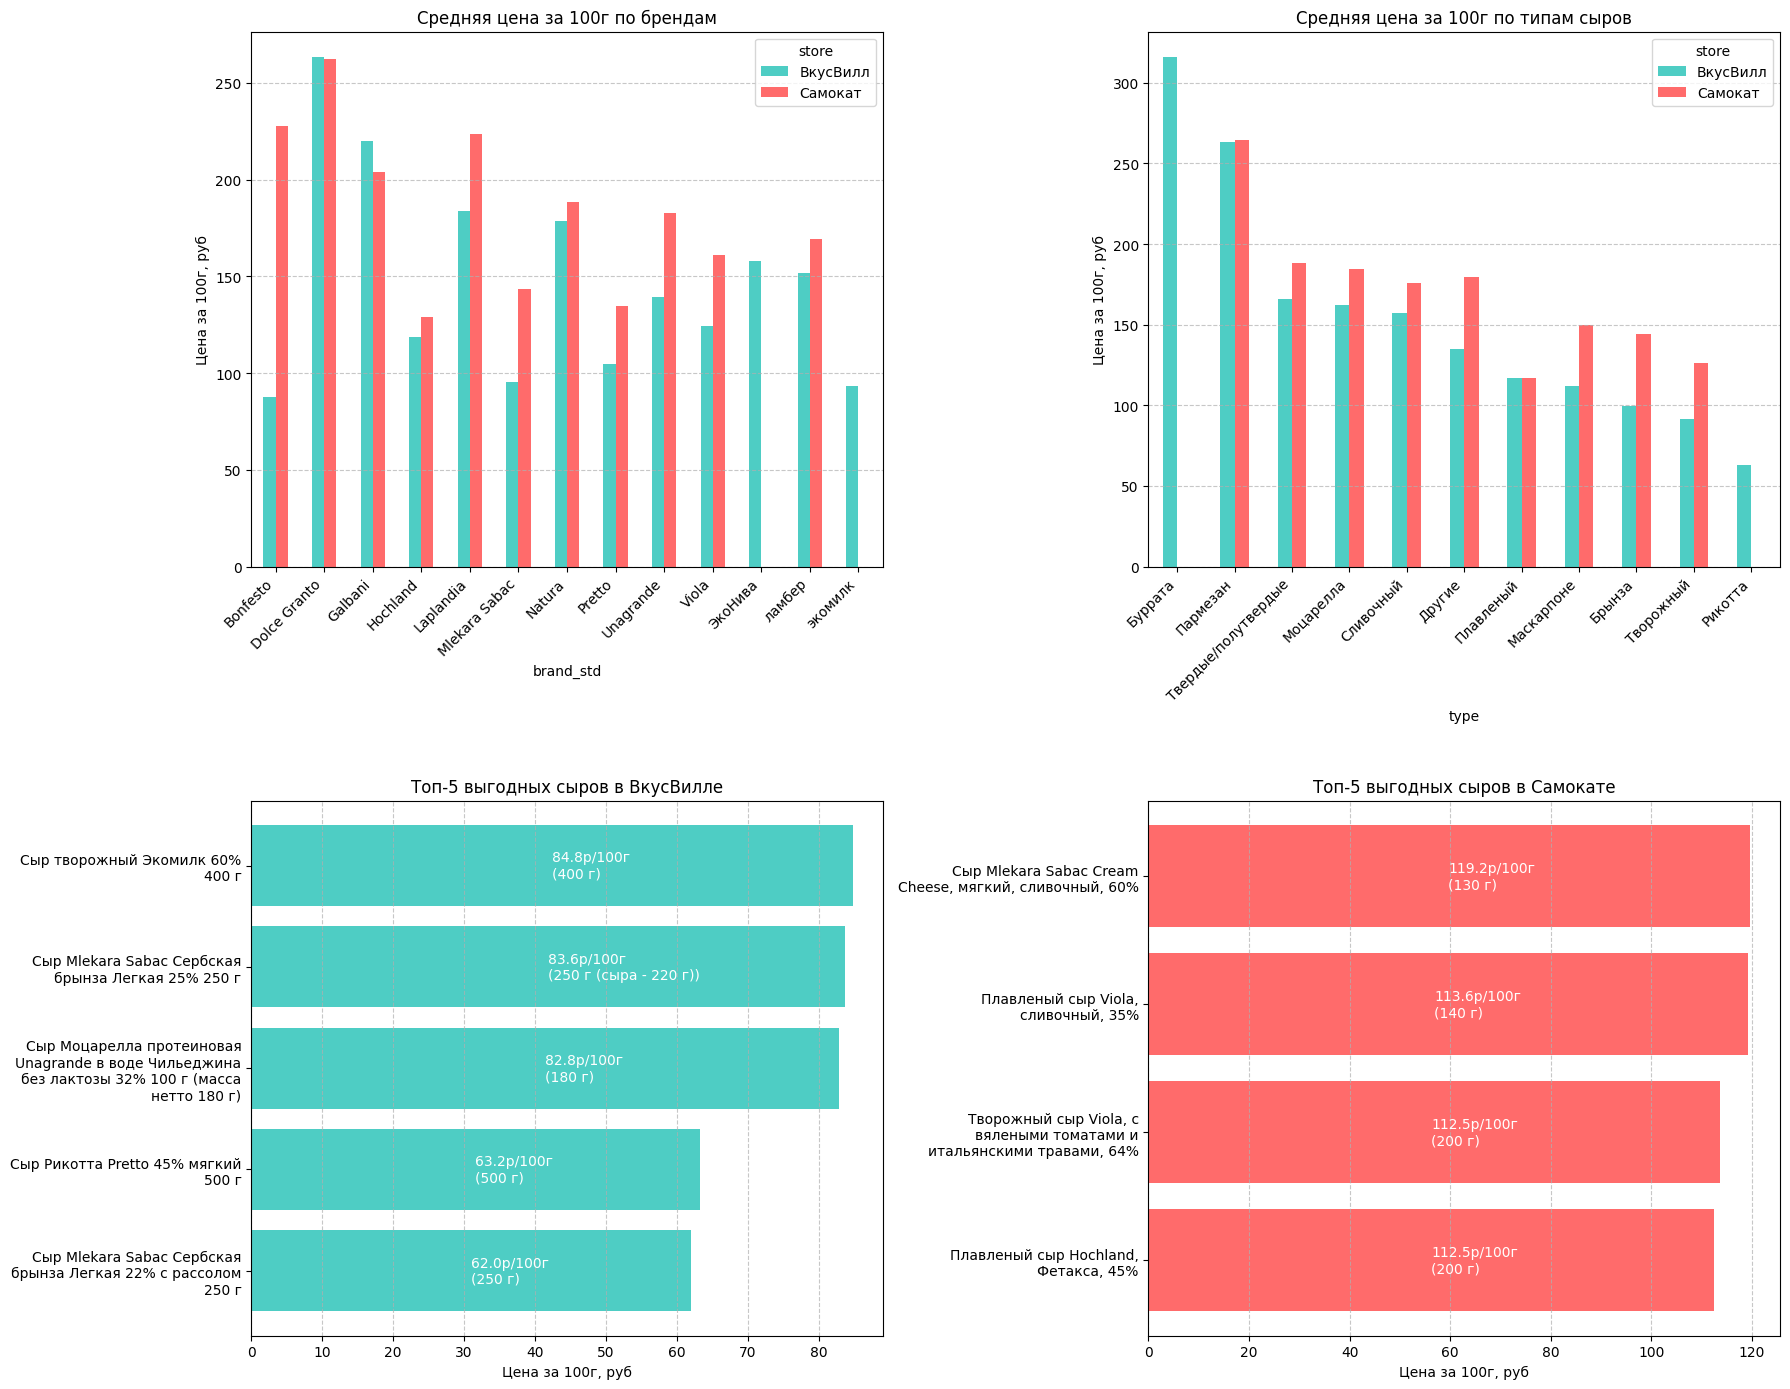

Топ-5 самых выгодных сыров в ВкусВилле:
                                                                                           name         brand  price               weight  price_per_100g
                                  Сыр Mlekara Sabac Сербская брынза Легкая 22% с рассолом 250 г Mlekara Sabac    155                250 г       62.000000
                                                            Сыр Рикотта Pretto 45% мягкий 500 г        Pretto    316                500 г       63.200000
Сыр Моцарелла протеиновая Unagrande в воде Чильеджина без лактозы 32% 100 г (масса нетто 180 г)     Unagrande    149                180 г       82.777778
                                             Сыр Mlekara Sabac Сербская брынза Легкая 25% 250 г Mlekara Sabac    209 250 г (сыра - 220 г)       83.600000
                                                                Сыр творожный Экомилк 60% 400 г       ЭКОМИЛК    339                400 г       84.750000

Топ-5 самых выгодных сыров в Самока

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
"""Визуализация категории "сыры" """


# Функция для обработки веса
def extract_weight(weight_str):
    if pd.isna(weight_str): return None
    weight_str = str(weight_str).replace(' ', '').replace('г', '')
    match = re.search(r'(\d+\.?\d*)', weight_str)
    return float(match.group(1)) if match else None

# Загрузка и обработка данных ВкусВилл
vkusvill = pd.read_csv('vkusvill_syry_filtered.csv')
vkusvill['weight_grams'] = vkusvill['weight'].apply(extract_weight)
vkusvill = vkusvill.dropna(subset=['weight_grams', 'price'])
vkusvill['price_per_100g'] = (vkusvill['price'] / vkusvill['weight_grams']) * 100
vkusvill['store'] = 'ВкусВилл'

# Загрузка и обработка данных Самокат
samokat = pd.read_csv('samokat_syry_filtered-3.csv')
samokat['weight_grams'] = samokat['weight'].apply(extract_weight)
samokat = samokat.dropna(subset=['weight_grams', 'price'])
samokat['price_per_100g'] = (samokat['price'] / samokat['weight_grams']) * 100
samokat['store'] = 'Самокат'

# Объединение данных
all_data = pd.concat([vkusvill, samokat])

# Функция для стандартизации названий брендов
def standardize_brand(name):
    name = str(name).lower()
    if 'viola' in name: return 'Viola'
    if 'lamber' in name: return 'Ламбер'
    if 'galbani' in name: return 'Galbani'
    if 'natura' in name: return 'Natura'
    if 'pretto' in name: return 'Pretto'
    if 'hochland' in name: return 'Hochland'
    if 'mlekara' in name: return 'Mlekara Sabac'
    if 'laplandia' in name: return 'Laplandia'
    if 'ekomilk' in name: return 'ЭКОМИЛК'
    if 'bonfesto' in name: return 'Bonfesto'
    if 'unagrande' in name: return 'Unagrande'
    if 'dolce' in name: return 'Dolce Granto'
    if 'экoнива' in name or 'эконива' in name: return 'ЭкоНива'
    return name

all_data['brand_std'] = all_data['brand'].apply(standardize_brand)

# Классификация сыров по типам
def classify_cheese(name):
    name = str(name).lower()
    if 'моцарел' in name: return 'Моцарелла'
    if 'пармезан' in name: return 'Пармезан'
    if 'брынз' in name: return 'Брынза'
    if 'творож' in name or 'кремчиз' in name: return 'Творожный'
    if 'плавлен' in name: return 'Плавленый'
    if 'сливоч' in name: return 'Сливочный'
    if 'гауда' in name or 'маасдам' in name or 'тильзитер' in name: return 'Твердые/полутвердые'
    if 'рикотт' in name: return 'Рикотта'
    if 'буррат' in name: return 'Буррата'
    if 'маскарпон' in name: return 'Маскарпоне'
    return 'Другие'

all_data['type'] = all_data['name'].apply(classify_cheese)

# Сравнение по брендам и типам
comparison = all_data.groupby(['brand_std', 'type', 'store'])['price_per_100g'].mean().unstack().reset_index()
comparison['price_diff'] = comparison['ВкусВилл'] - comparison['Самокат']
comparison['diff_percent'] = (comparison['price_diff'] / comparison['Самокат']) * 100

# Топ-5 самых выгодных позиций в каждом магазине
top_vkusvill = vkusvill.nsmallest(5, 'price_per_100g')
top_samokat = samokat.nsmallest(5, 'price_per_100g')

# Визуализация
plt.figure(figsize=(18, 14))

# График 1: Сравнение средних цен по брендам
plt.subplot(2, 2, 1)
brand_prices = all_data.groupby(['brand_std', 'store'])['price_per_100g'].mean().unstack()
brand_prices.plot(kind='bar', ax=plt.gca(), color=['#4ECDC4', '#FF6B6B'])
plt.title('Средняя цена за 100г по брендам')
plt.ylabel('Цена за 100г, руб')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# График 2: Сравнение по типам сыров
plt.subplot(2, 2, 2)
type_prices = all_data.groupby(['type', 'store'])['price_per_100g'].mean().unstack()
type_prices = type_prices.sort_values(by='ВкусВилл', ascending=False)
type_prices.plot(kind='bar', ax=plt.gca(), color=['#4ECDC4', '#FF6B6B'])
plt.title('Средняя цена за 100г по типам сыров')
plt.ylabel('Цена за 100г, руб')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# График 3: Топ-5 выгодных в ВкусВилле
plt.subplot(2, 2, 3)
plt.barh(
    top_vkusvill['name'].str.wrap(30),
    top_vkusvill['price_per_100g'],
    color='#4ECDC4'
)
for i, (price, weight) in enumerate(zip(top_vkusvill['price_per_100g'], top_vkusvill['weight'])):
    plt.text(price/2, i, f"{price:.1f}р/100г\n({weight})", va='center', color='white')
plt.title('Топ-5 выгодных сыров в ВкусВилле')
plt.xlabel('Цена за 100г, руб')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# График 4: Топ-5 выгодных в Самокате
plt.subplot(2, 2, 4)
plt.barh(
    top_samokat['name'].str.wrap(30),
    top_samokat['price_per_100g'],
    color='#FF6B6B'
)
for i, (price, weight) in enumerate(zip(top_samokat['price_per_100g'], top_samokat['weight'])):
    plt.text(price/2, i, f"{price:.1f}р/100г\n({weight})", va='center', color='white')
plt.title('Топ-5 выгодных сыров в Самокате')
plt.xlabel('Цена за 100г, руб')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('cheese_price_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Вывод результатов
print("Топ-5 самых выгодных сыров в ВкусВилле:")
print(top_vkusvill[['name', 'brand', 'price', 'weight', 'price_per_100g']].to_string(index=False))

print("\nТоп-5 самых выгодных сыров в Самокате:")
print(top_samokat[['name', 'brand', 'price', 'weight', 'price_per_100g']].to_string(index=False))

print("\nСравнение средних цен по брендам и типам:")
print(comparison[['brand_std', 'type', 'ВкусВилл', 'Самокат', 'price_diff', 'diff_percent']].to_string(index=False))

**Основные выводы:** 
Самокат чаще предлагает более выгодные цены на базовые продукты (фарш, куриное филе, твёрдые сыры, простые макароны). Это может быть связано с их стратегией привлечения клиентов через низкие цены на популярные товары.

ВкусВилл выигрывает в сегменте премиальных и специализированных продуктов (органические сыры, макароны с соусами, мясные деликатесы). Это соответствует их позиционированию как магазина "для гурманов".

Разброс цен в ВкусВилле выше: есть как очень дорогие, так и дешёвые товары, тогда как "Самокат" придерживается более однородного ценника.

**Анализ по категориям:**

*Самокат* дешевле на 15-30% для:

Курицы (филе, бедро, голень)

Фарша (особенно бренды "Мираторг", "Троекурово")

Стейков из свинины

*ВкусВилл* выгоднее для:

Колбасных изделий (разница до 20%)

Субпродуктов (печень, рулеты)

Эко-мясных продуктов (бренды "Индилайт", "Ближние горки")

**Почему?**
  
Самокат делает ставку на массовые мясные продукты с высоким оборотом, а ВкусВилл фокусируется на нишевых товарах (фермерское мясо, деликатесы).


**Макароны:**

*Самокат* лидирует по ценам на:

Спагетти и вермишель (дешевле на 10-25%)

Макароны с сырным соусом

*ВкусВилл* предлагает лучшие цены для:

Лазаньи (разница до 15%)

Органических макарон (бренды "Makfa", "Barilla")

**Почему?**

"ВкусВилл" импортирует итальянские макароны крупными партиями, снижая закупочную стоимость. 
"Самокат" же работает с локальными производителями.

**Сыры:**

*Самокат* выгоднее для:

Твёрдых сыров (типа "Гауда", "Маасдам")

Плавленых сыров (разница до 40%!)

Творожных сыров (бренды "Viola", "Hochland")

*ВкусВилл* дешевле в сегменте:

Моцареллы (особенно "Galbani")

Брынзы и сыров с плесенью

Органических сыров ("ЭКОМИЛК")

**Почему?**
 Самокат продаёт сыры масс-маркет в больших упаковках, а ВкусВилл делает акцент на малых фасовках для пробных покупок.


**Инсайты для окупателей**

В *Самокате* выгодно брать: курицу, фарш, простые макароны, плавленые сыры.

Во *ВкусВилле* – колбасы, моцареллу, лазанью, фермерские продукты.

При заказе от 3-5 товаров одной категории Самокат часто предлагает дополнительные скидки.

ВкусВилл выгоден для разовых покупок премиальных товаров (разница в 100-200 руб. на сырах не критична, если берёте 1 упаковку).
